In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers.descriptors import Section

from yaml import load
from yaml.loader import Loader
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

In [2]:
font = {'family' : 'DejaVu Sans',
        'sans-serif': "Arial",
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10

In [3]:
BASENAME = "3rdGallery"
section_count = 195
fp = "../../real_data/02_GrotteDeLaCascadeDeMotiers/params.yaml"

params = load(open(fp), Loader)

GLOBAL_SHIFT = params["alignment"]["globalShift"]

In [4]:
sections = []

for i in range(1,section_count):
    data = np.loadtxt(f"../../real_data/02_GrotteDeLaCascadeDeMotiers/process/sections_as_polylines/{BASENAME}_unordered_section_{i}.txt")

    # recentre the data to barycentre
    sections.append(data)
    
    

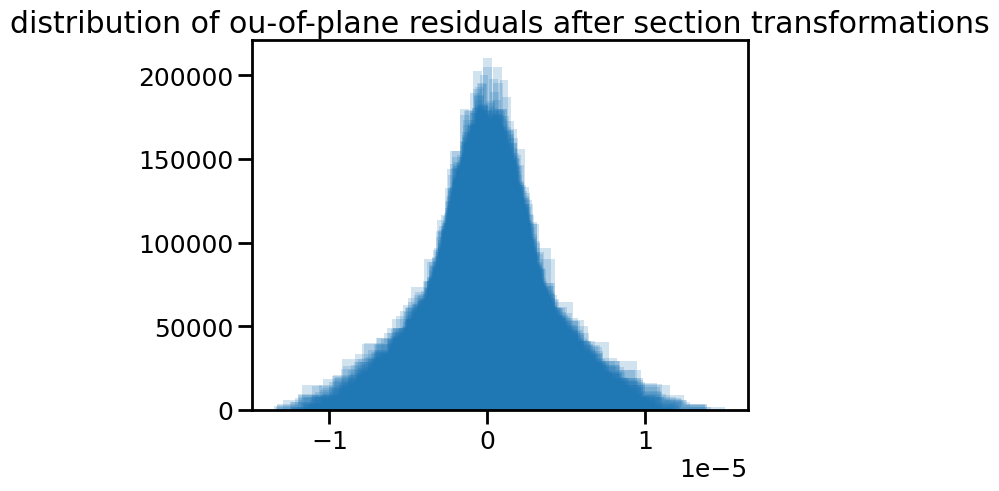

In [5]:
for data in sections:
    plt.hist(data[:, 1] - np.mean(data[:, 1]), density = True, alpha = 0.2, bins = 20, color = "C0")

plt.title("distribution of ou-of-plane residuals after section transformations");

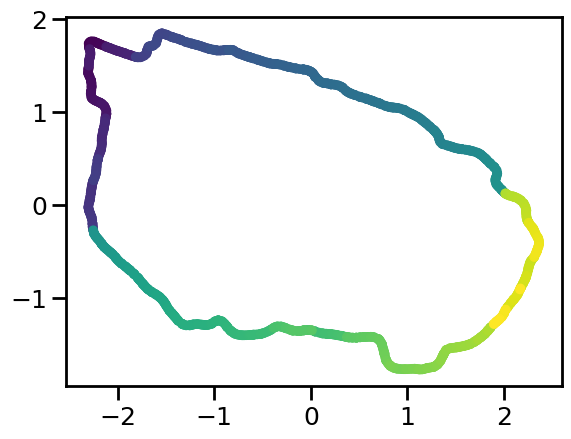

In [6]:
fig, ax = plt.subplots()
idx = np.arange(0, len(sections[1]))
ax.scatter(sections[1][ :, 0], sections[1][ :, 2], c= idx)

In [7]:
def order_points(points, ind):
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    k = 0
    while len(points)>0 and k <= 1e4:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
        k+=1
    if k == 1e4:
        print("max iterations reached")
    return np.array(points_new)

In [10]:
ordered = []

for data in sections[:212]:
    data = order_points(data.tolist(), 0)
    dists = np.linalg.norm(np.diff(data, axis = 0), axis = 1)
    id0 = 0
    idx = -1
    if np.any(dists > 0.2):
        print("likely several segments")
        split = np.argwhere(dists > 0.2).flatten()
        print(split)
        split_data = np.array(np.split(data, split), dtype =object)
        ind = np.argmax(np.array([len(seg) for seg in split_data]))
    
        data = split_data[ind]

    # recentre to barycentre
    data = data - np.mean(data, axis = 0)
    # check if closed: 
    closure = np.linalg.norm(data[-1] - data[0])
    if closure > 0.2:
        print("there may be a closure error")
        s = Section(data, flag= "ClosureError")
    else: 
        s = Section(data, flag= "all ok")
    ordered.append(s)


likely several segments
[1258]
likely several segments
[1341]
likely several segments
[1517 1553]
likely several segments
[1349]
likely several segments
[50]
there may be a closure error
likely several segments
[42]
there may be a closure error
likely several segments
[1445]
likely several segments
[1435]
likely several segments
[1326]
likely several segments
[1366]
likely several segments
[1341]
likely several segments
[1488]
likely several segments
[1325]
likely several segments
[1261]
likely several segments
[1260]
likely several segments
[1267]
likely several segments
[1167 1199]
likely several segments
[1304]
likely several segments
[1367 1443]
likely several segments
[1443]
likely several segments
[1336 1435]
there may be a closure error
likely several segments
[35]
there may be a closure error
likely several segments
[1520]
likely several segments
[1608]
likely several segments
[1613]
likely several segments
[1284]
likely several segments
[1308]
likely several segments
[1435]
li

In [11]:
for section in ordered:
    section.compute_descriptors()

In [12]:
# curvilinear coordinates
planes_origin = np.loadtxt(f"../../real_data/02_GrotteDeLaCascadeDeMotiers/process/planes_as_vectors/{BASENAME}_Planes_Origin.txt")
xi = np.cumsum(np.linalg.norm(np.diff(planes_origin, axis = 0), axis = 1))

In [13]:
good_sections = [n for n,section in enumerate(ordered) if section.flag != "ClosureError"]
bad_sections = [n for n,section in enumerate(ordered) if section.flag == "ClosureError"]

sections_ok = [section.points2d for section in ordered if section.flag != "ClosureError"]
areas_ok = [section.area for section in ordered if section.flag != "ClosureError"]
dh_ok = [section.hydraulic_diameter for section in ordered if section.flag != "ClosureError" ]
sol_ok = [section.solidity for section in ordered if section.flag != "ClosureError" ]
areas_bad = [section.area for section in ordered if section.flag == "ClosureError"]
dh_bad = [section.hydraulic_diameter for section in ordered if section.flag == "ClosureError" ]
sol_bad = [section.solidity for section in ordered if section.flag == "ClosureError" ]

In [14]:
# find the min and max of each descriptor to highlight them 

max_area = np.argmax(areas_ok)
min_area = np.argmin(areas_ok)

max_dh = np.argmax(dh_ok)
min_dh = np.argmin(dh_ok)

max_sol = np.argmax(sol_ok)
min_sol = np.argmin(sol_ok)

In [15]:
def plotDH(indx, ax):
    dh = ordered[good_sections[indx]].hydraulic_diameter
    xi = np.linspace(0, 2*np.pi, 100)
    # upper semi-circle
    ax.fill_between(1/2*dh*np.cos(xi), 0 , 1/2*dh*np.sin(xi), alpha = 0.66, color = "grey", edgecolor=None)
    return ax
    

In [16]:
def plotCHull(indx, ax):
    chull = ordered[good_sections[indx]].convexhull
    chull_wrapped = np.zeros((len(chull)+1, 2))
    chull_wrapped[:-1] = chull
    chull_wrapped[-1] = chull[0]
    
    ax.plot(chull_wrapped[:,0], chull_wrapped[:, 1], zorder = -10, color = "C1")
    return ax

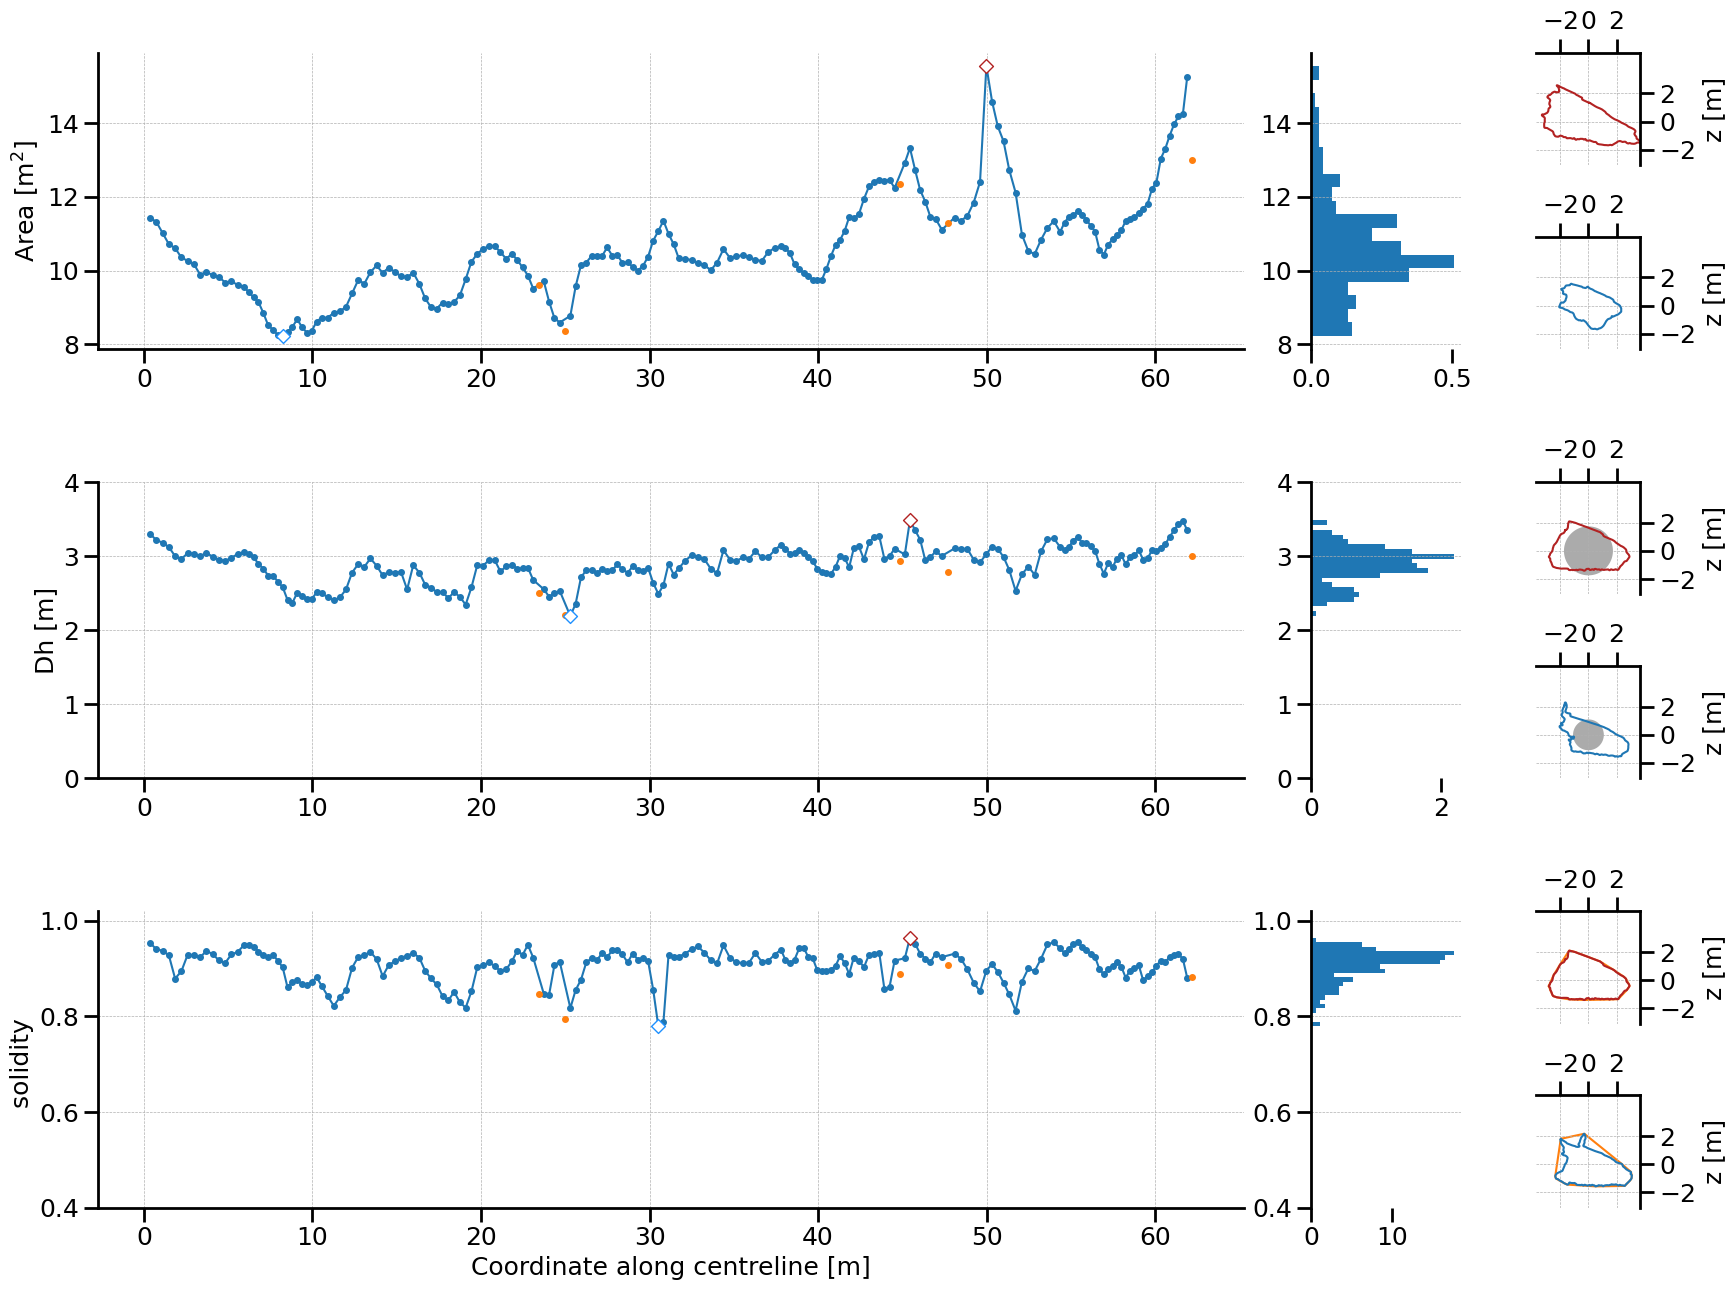

In [17]:
fig = plt.figure(figsize = (20, 15))
gs = GridSpec(19, 50)
ax1 = fig.add_subplot(gs[0:5, :37])
ax2 = fig.add_subplot(gs[7:12, :37], sharex = ax1)
ax3 = fig.add_subplot(gs[14:, :37], sharex = ax1)

ax2.set_ylim(0, 4)
ax3.set_ylim(0.4, 1.02)

ax1_hist = fig.add_subplot(gs[0:5, 39:44], sharey = ax1)
ax2_hist = fig.add_subplot(gs[7:12, 39:44], sharey = ax2)
ax3_hist = fig.add_subplot(gs[14:, 39:44], sharey = ax3)

ax1.plot(xi[good_sections], areas_ok, "-o", markersize = 4)
ax2.plot(xi[good_sections], dh_ok, "-o", markersize = 4)
ax3.plot(xi[good_sections], sol_ok, "-o", markersize = 4)
ax1_hist.hist(areas_ok, density = True, orientation = "horizontal", bins = 20)
ax2_hist.hist(dh_ok, density = True, orientation = "horizontal", bins = 20)
ax3_hist.hist(sol_ok, density = True, orientation = "horizontal", bins = 20)

ax1.plot(xi[bad_sections], areas_bad, "o", markersize = 4)
ax2.plot(xi[bad_sections], dh_bad, "o", markersize = 4)
ax3.plot(xi[bad_sections], sol_bad, "o",markersize = 4)

labels = ["Area [m$^2$]", "Dh [m]", "solidity "]
for ax, label in zip((ax1,ax2,ax3), labels):
    ax.set_ylabel(label)
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)
        ax.grid(lw = 0.5, ls="--")
for ax in (ax1_hist,ax2_hist,ax3_hist):
    for spine in ["top","bottom","right"]:
        ax.spines[spine].set_visible(False)
    
    ax.grid(axis= "y", lw = 0.5, ls="--")

ax3.set_xlabel("Coordinate along centreline [m]")

ax1_inset1 = fig.add_subplot(gs[0:2, 46:])
ax1_inset2 = fig.add_subplot(gs[3:5, 46:], sharex = ax1_inset1, sharey = ax1_inset1)

ax1_inset1.plot(sections_ok[max_area][:,0], sections_ok[max_area][:,1], color = "firebrick")
ax1_inset2.plot(sections_ok[min_area][:,0], sections_ok[min_area][:,1])
ax1.scatter(xi[good_sections][max_area], areas_ok[max_area], color = "white",  edgecolor = "firebrick", zorder = 100, s = 50, marker = "D")
ax1.scatter(xi[good_sections][min_area], areas_ok[min_area], color = "white", edgecolor = "dodgerblue", zorder = 100, s = 50, marker = "D")

ax2_inset1 = fig.add_subplot(gs[7:9, 46:], sharex = ax1_inset1,  sharey = ax1_inset1)
ax2_inset2 = fig.add_subplot(gs[10:12, 46:], sharex = ax1_inset1,  sharey = ax1_inset1)

ax2_inset1.plot(sections_ok[max_dh][:,0], sections_ok[max_dh][:,1], color = "firebrick")
ax2_inset2.plot(sections_ok[min_dh][:,0], sections_ok[min_dh][:,1])
ax2.scatter(xi[good_sections][max_dh], dh_ok[max_dh], color = "white",  edgecolor = "firebrick", zorder = 100, s = 50, marker = "D")
ax2.scatter(xi[good_sections][min_dh], dh_ok[min_dh], color = "white", edgecolor = "dodgerblue", zorder = 100, s = 50, marker = "D")
plotDH(max_dh, ax2_inset1)
plotDH(min_dh, ax2_inset2)


ax3_inset1 = fig.add_subplot(gs[14:16, 46:], sharex = ax1_inset1,  sharey = ax1_inset1)
ax3_inset2 = fig.add_subplot(gs[17:19, 46:], sharex = ax1_inset1,  sharey = ax1_inset1)

ax3_inset1.plot(sections_ok[max_sol][:,0], sections_ok[max_sol][:,1], color = "firebrick")
ax3_inset2.plot(sections_ok[min_sol][:,0], sections_ok[min_sol][:,1])
ax3.scatter(xi[good_sections][max_sol], sol_ok[max_sol], color = "white",  edgecolor = "firebrick", zorder = 100, s = 50, marker = "D")
ax3.scatter(xi[good_sections][min_sol], sol_ok[min_sol], color = "white", edgecolor = "dodgerblue", zorder = 100, s = 50, marker = "D")

plotCHull(max_sol, ax3_inset1)
plotCHull(min_sol, ax3_inset2)

for ax in (ax1_inset1, ax1_inset2,ax2_inset1,ax2_inset2,ax3_inset1,ax3_inset2 ):
    ax.set_aspect("equal")
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_visible(False)
    ax.grid(lw = 0.5, ls="--")
    #ax.set_xlim(-2.5, 2.5)
    #ax.set_ylim(-2.1, 2.9)
    ax.set_xlim(-3.7, 3.7)
    ax.set_ylim(-3.1, 4.9)
    ax.set_xticks([-2,0,2])
    ax.set_yticks([-2,0,2])
    ax.tick_params(top=True, right=True, left = False, bottom= False)
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("z [m]")

plt.savefig(f"{BASENAME}_stats.pdf")

In [18]:
np.sqrt(len(dh_ok)-1)

13.711309200802088

In [19]:
print("mean hydraulic radius: {:.3f}".format(np.mean(dh_ok)))
print("hydraulic std: {:.4f}".format(np.std(dh_ok)))

mean hydraulic radius: 2.892
hydraulic std: 0.2435


In [20]:
nsim = 1000
dh_bootstrap = np.zeros((nsim))
for sim in range(nsim):
    dh_bootstrap[sim] = np.mean(np.random.choice(dh_ok,len(dh_ok), replace=True))

print(np.mean(dh_bootstrap))
print(np.std(dh_bootstrap))

2.8926172100582215
0.01770143702898069


In [425]:
print("mean solidity: {:.2f}".format(np.mean(sol_ok[1:])))
print("solidity std: {:.2f}".format(np.std(sol_ok[1:])))

mean solidity: 0.91
solidity std: 0.03


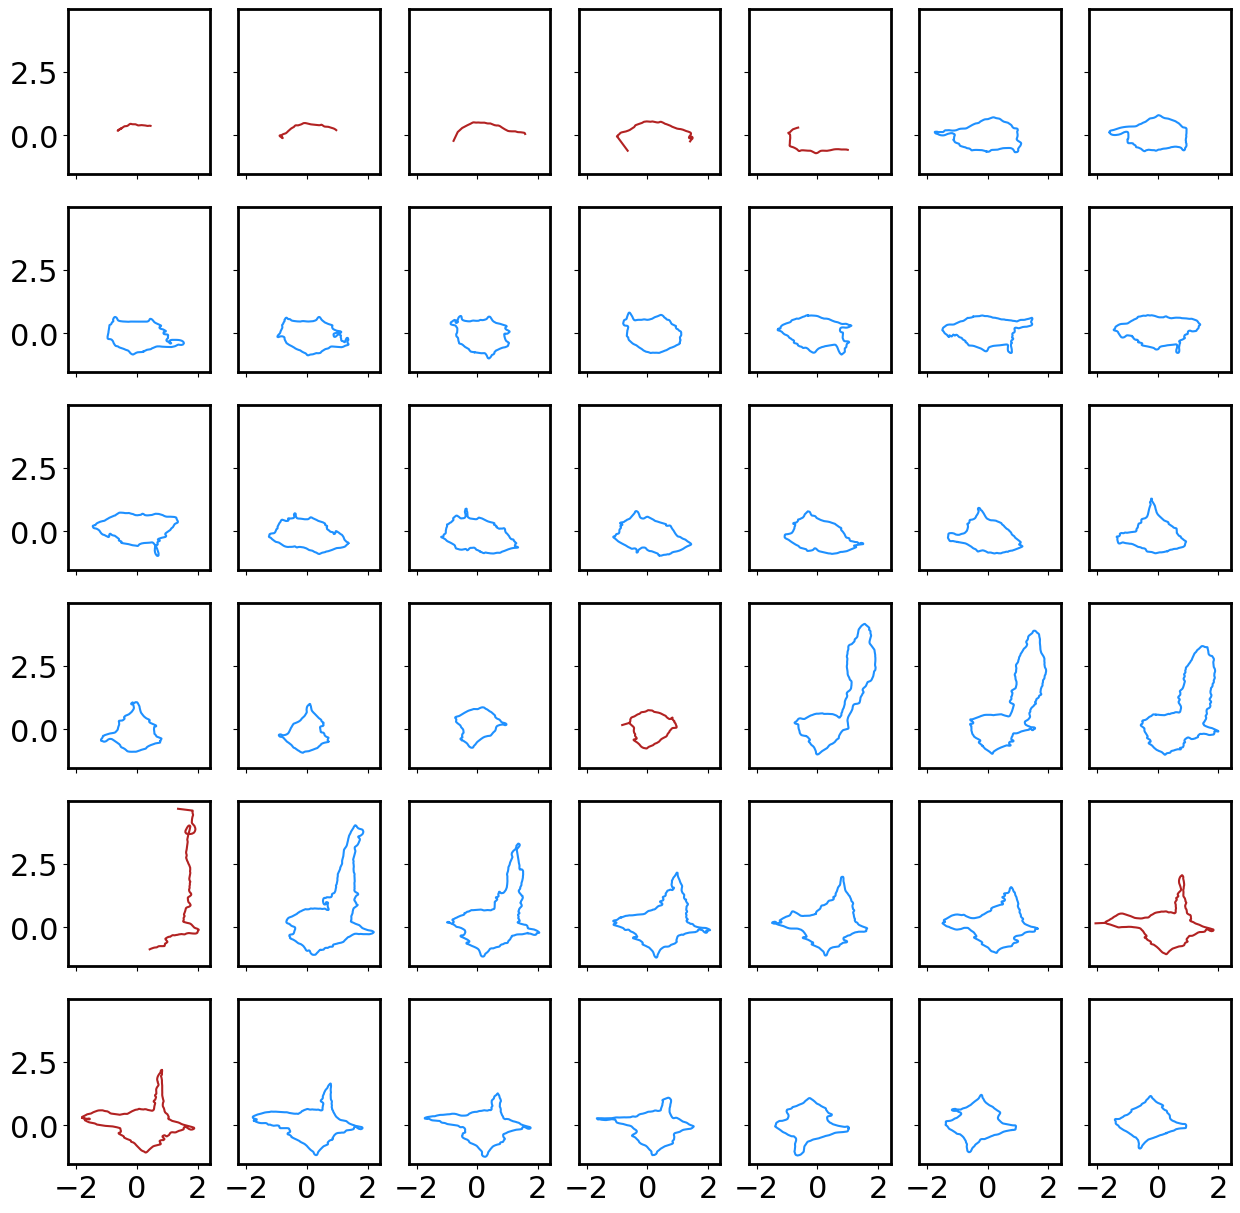

In [208]:
fig, axes = plt.subplots(6, 7, sharex= True, sharey=True, figsize= (15, 15))

for section, ax in zip(ordered[0:42], axes.flatten()):
    if section.flag == "ClosureError":
        ax.plot(section.points2d[:,0], section.points2d[:,1], color = "firebrick")
    else: 
        ax.plot(section.points2d[:,0], section.points2d[:,1], color = "dodgerblue")
        
